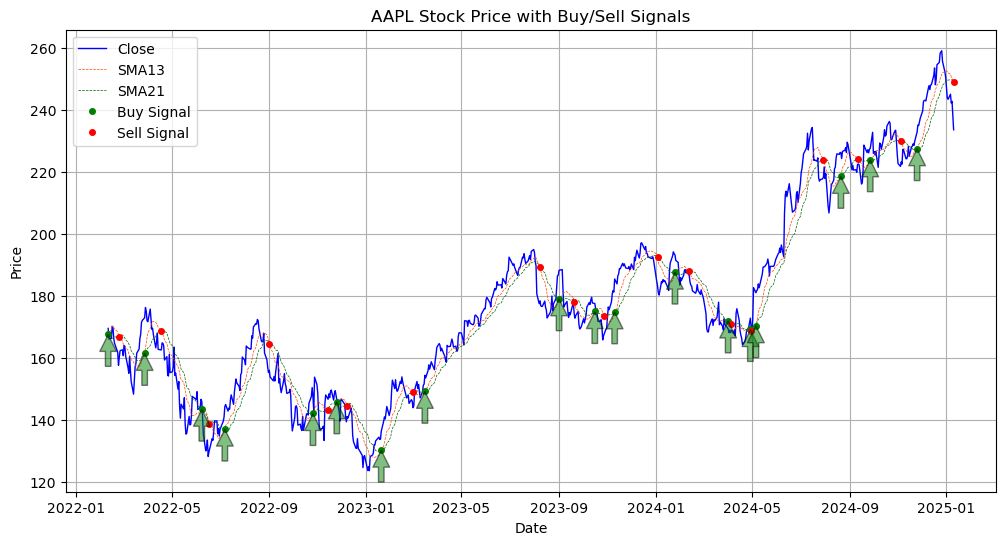

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

aapl_price_history=yf.Ticker('AAPL').history(start='2022-01-01')#,end='2021-01-01')
aapl_price_history.dropna(inplace=True)

windows=[13,21]
# when the short term moving average is above the long term moving average, the stock is considered bullish

for window in windows:
    aapl_price_history['SMA'+str(window)]=aapl_price_history['Close'].rolling(window=window).mean()

# Create crossover signals
aapl_price_history['SMA_cross'] = np.where(
    aapl_price_history['SMA13'] > aapl_price_history['SMA21'], 1, -1)
# Find where the signal changes (crossover points)
aapl_price_history['crossover'] = aapl_price_history['SMA_cross'].diff()

# Get dates where crossovers occur
crossover_dates = aapl_price_history[aapl_price_history['crossover'] != 0]
first_buy_date = crossover_dates[crossover_dates['crossover'] == 2].index[0]
last_sell_date = crossover_dates[crossover_dates['crossover'] == -2].index[-1]

crossover_dates = crossover_dates.loc[first_buy_date:last_sell_date]
aapl_price_history = aapl_price_history.loc[first_buy_date:last_sell_date]

plt.figure(figsize=(12,6))

plt.plot(aapl_price_history['Close'],label='Close',linestyle='-',linewidth=1,color='blue')
plt.plot(aapl_price_history['SMA13'],label='SMA13',linestyle='--',linewidth=.5,color='orangered')
plt.plot(aapl_price_history['SMA21'],label='SMA21',linestyle='--',linewidth=.5,color='darkgreen')

plt.plot(crossover_dates[crossover_dates['crossover']==2].index, crossover_dates[crossover_dates['crossover']==2]['SMA13'], 'go', label='Buy Signal', markersize=4)
for idx in crossover_dates[crossover_dates['crossover']==2].index:
    plt.annotate('', xy=(idx, crossover_dates.loc[idx, 'SMA13']), fontsize=8,
                xytext=(idx, crossover_dates.loc[idx, 'SMA13']-15),
                arrowprops=dict(facecolor='green', shrink=0.01,alpha=0.5),
                bbox=dict(boxstyle='round,pad=0.5', fc='green', alpha=0.5))
plt.plot(crossover_dates[crossover_dates['crossover']==-2].index, crossover_dates[crossover_dates['crossover']==-2]['SMA13'], 'ro', label='Sell Signal', markersize=4)

plt.legend()
#plt.xlim('2020-01-01','2021-01-01')
plt.grid()
plt.title('AAPL Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig('AAPL_stock_price.png',dpi=300,bbox_inches='tight')
plt.show()

In [18]:
# Create a copy of the dataframe to avoid the SettingWithCopyWarning
crossover_dates = crossover_dates.copy()
crossover_dates.dropna(inplace=True)
crossover_dates['return'] = np.where(crossover_dates['crossover']==2, 0, crossover_dates['Close'].pct_change())
crossover_dates['value'] = (1+crossover_dates['return']).cumprod()

returns=crossover_dates['return'].to_numpy(dtype=float)
returns=returns[returns!=0]
total_return = np.prod(1+returns)-1
print(f'Stock return without trading: {aapl_price_history['Close'].iloc[-1]*100/aapl_price_history['Close'].iloc[0]:,.2f}%')
print(f'Total return with trading: {total_return*100:,.2f}%')
print('Number of trades:',len(crossover_dates))
print('Hit rate:',len(returns[returns>0])/len(returns))
print(f'Total time: {crossover_dates.index[-1]-crossover_dates.index[0]}')


Stock return without trading: 137.60%
Total return with trading: -5.31%
Number of trades: 36
Hit rate: 0.2777777777777778
Total time: 1065 days 00:00:00


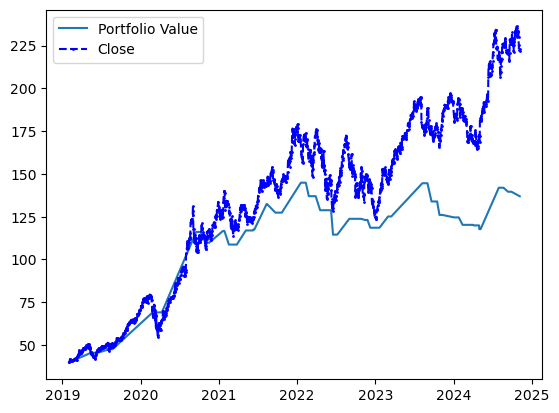

In [15]:
plt.plot(crossover_dates.index, crossover_dates['value']*crossover_dates['Close'].iloc[0], label='Portfolio Value')
plt.plot(aapl_price_history['Close'],label='Close',linestyle='--',marker='o',markersize=1,color='blue')
plt.legend()
plt.show()